# Config

In [2]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 92.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 76.6 MB/s eta 0:00:00


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from transformers import AutoModel, AutoTokenizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from underthesea import word_tokenize
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class Config:
    """Configuration class for hyperparameters"""
    model_name = "demdecuong/vihealthbert-base-word"
    max_length = 256
    batch_size = 16
    learning_rate = 2e-5 # ~ 0.00002
    weight_decay = 0.01
    num_epochs = 20
    warmup_steps = 100
    dropout_rate = 0.3
    hidden_size = 128
    patience = 5
    gradient_clip = 1.0

# Model DiseaseClass

In [4]:
class DiseaseClassifier(nn.Module):
    """Enhanced classifier for disease prediction"""
    def __init__(self, pretrained_model, num_labels, config):
        super(DiseaseClassifier, self).__init__()
        self.bert = pretrained_model
        self.config = config

        # Freeze some layers for better transfer learning
        for param in self.bert.embeddings.parameters():
            param.requires_grad = False

        # Enhanced classifier head
        self.dropout1 = nn.Dropout(config.dropout_rate)
        self.fc1 = nn.Linear(self.bert.config.hidden_size, config.hidden_size)
        self.dropout2 = nn.Dropout(config.dropout_rate)
        self.fc2 = nn.Linear(config.hidden_size, config.hidden_size // 2)
        self.dropout3 = nn.Dropout(config.dropout_rate)
        self.classifier = nn.Linear(config.hidden_size // 2, num_labels)

        # Layer normalization
        self.layer_norm1 = nn.LayerNorm(config.hidden_size)
        self.layer_norm2 = nn.LayerNorm(config.hidden_size // 2)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        """Initialize weights properly"""
        for module in [self.fc1, self.fc2, self.classifier]:
            nn.init.xavier_normal_(module.weight)
            nn.init.constant_(module.bias, 0)

    def forward(self, input_ids, attention_mask=None):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Use mean pooling instead of just CLS token
        last_hidden_state = outputs.last_hidden_state

        # Mean pooling with attention mask
        if attention_mask is not None:
            mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
            sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
            sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
            pooled_output = sum_embeddings / sum_mask
        else:
            pooled_output = torch.mean(last_hidden_state, 1)

        # Forward through enhanced classifier
        x = self.dropout1(pooled_output)
        x = F.relu(self.layer_norm1(self.fc1(x)))
        x = self.dropout2(x)
        x = F.relu(self.layer_norm2(self.fc2(x)))
        x = self.dropout3(x)
        logits = self.classifier(x)

        return logits


In [ ]:
class EarlyStopping:
    """Early stopping to prevent overfitting"""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

In [10]:
class HealthBERTTrainer:
    """Enhanced trainer class for disease prediction"""
    def __init__(self, model, train_loader, val_loader, config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        # Move model to device
        self.model.to(self.device)

        # Optimizer with weight decay
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=config.learning_rate,
            weight_decay=config.weight_decay
        )

        # Learning rate scheduler
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            factor=0.5,
            patience=3,
            verbose=True
        )

        # Early stopping
        self.early_stopping = EarlyStopping(patience=config.patience)

        # Loss function with label smoothing
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

        # Training history
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_acc': [],
            'val_acc': []
        }

    def train_epoch(self):
        """Train one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        progress_bar = tqdm(self.train_loader, desc="Training")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(input_ids, attention_mask)
            loss = self.criterion(logits, labels)

            # Backward pass
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.gradient_clip)

            self.optimizer.step()

            # Statistics
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update progress bar
            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

        return total_loss / len(self.train_loader), 100. * correct / total

    def validate(self):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(self.val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                logits = self.model(input_ids, attention_mask)
                loss = self.criterion(logits, labels)

                total_loss += loss.item()
                _, predicted = torch.max(logits.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        return total_loss / len(self.val_loader), 100. * correct / total, all_preds, all_labels

    def train(self):
        """Full training loop"""
        print(f"Training on device: {self.device}")
        print(f"Model parameters: {sum(p.numel() for p in self.model.parameters()):,}")

        best_val_loss = float('inf')

        for epoch in range(self.config.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.config.num_epochs}")
            print("-" * 50)

            # Train
            train_loss, train_acc = self.train_epoch()

            # Validate
            val_loss, val_acc, val_preds, val_labels = self.validate()

            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_acc'].append(val_acc)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_disease_model.pth')
                print("✓ Saved new best model")

            # Early stopping
            if self.early_stopping(val_loss):
                print(f"Early stopping triggered after {epoch+1} epochs")
                break

        # Load best model
        self.model.load_state_dict(torch.load('best_disease_model.pth'))
        return self.history

In [11]:
def evaluate_model(model, val_loader, label_encoder, device):
    """Comprehensive model evaluation"""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            logits = model(input_ids, attention_mask)
            _, predicted = torch.max(logits, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted', zero_division=0)

    print(f"\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Classification report
    class_names = label_encoder.classes_
    all_label_indices = list(range(len(class_names)))
    print("\nDetailed Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, labels=all_label_indices, zero_division=0))

    return accuracy, precision, recall, f1

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss plot
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)

    # Accuracy plot
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_acc'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


# Load Dataset

In [ ]:
def preprocess_text(text):
    """Enhanced text preprocessing for Vietnamese medical text"""
    if isinstance(text, str):
        # Word tokenization for Vfietnamese
        segmented = word_tokenize(text, format="text")
        return segmented.strip()
    return ""

In [13]:
import pandas as pd
class DiseaseDataset(Dataset):
    """Dataset class for disease prediction from symptoms"""
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize with proper padding and truncation
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [14]:
def create_disease_dataset(excelpath):
    """
    Tạo dataset bệnh từ file Excel - chỉ lấy cột 1 (bệnh) và cột 2 (triệu chứng)
    """
    try:
        # Đọc file Excel
        df = pd.read_csv(excel_path)
        print(f"Đã đọc {len(df)} dòng dữ liệu từ file csv")

        # Lấy cột 0 (bệnh) và cột 1 (triệu chứng)
        df = df.iloc[:, [0, 1]]  # Cột 0 và cột 1
        df.columns = ['benh', 'trieu_chung']  # Đặt tên cột

        # Loại bỏ các dòng có giá trị null
        df = df.dropna()

        # Chuẩn hóa tên bệnh: thay khoảng trắng bằng dấu gạch dưới
        df['benh'] = df['benh'].str.replace(' ', '_')

        # Tạo mảng tuple (triệu_chứng, bệnh)
        disease_data = []
        for _, row in df.iterrows():
            disease_data.append((str(row['trieu_chung']), str(row['benh'])))

        print(f"Đã tạo {len(disease_data)} mẫu dữ liệu")

        return disease_data

    except Exception as e:
        print(f"Lỗi khi đọc file Excel: {e}")
        return []

# Train Model

In [ ]:
excel_path = "/data_processed/augmented_medical_data.csv"

# Tạo dataset
disease_data = create_disease_dataset(excel_path)

# Hiển thị một số mẫu đầu
if disease_data:
    print("\nMột số mẫu dữ liệu:")
    for i, (symptom, disease) in enumerate(disease_data[:10]):
        print(f"{i+1}. ('{symptom}', '{disease}')")

    print(f"\nTổng cộng: {len(disease_data)} mẫu dữ liệu")
else:
    print("Không có dữ liệu")

Đã đọc 240 dòng dữ liệu từ file csv
Đã tạo 240 mẫu dữ liệu

Một số mẫu dữ liệu:
1. ('tôi xuất hiện phân có máu cùng với da lạnh, không có nước tiểu, buồn nôn', 'tiêu_chảy')
2. ('tôi gặp phải da lạnh kèm theo khô da, đầy hơi, ít hay không có nước mắt khi khóc', 'tiêu_chảy')
3. ('tôi có dấu hiệu khô đồng thời chuột rút, da lạnh, mệt mỏi', 'tiêu_chảy')
4. ('tôi gặp phải phân có máu cùng với nước tiểu màu vàng đậm, buồn nôn, nước tiểu rất ít', 'tiêu_chảy')
5. ('tôi có dấu hiệu phân có máu đồng thời khô da, không có nước tiểu, nước tiểu rất ít', 'tiêu_chảy')
6. ('tôi phát hiện da lạnh cùng với khô da, chóng mặt, ít hay không có nước mắt khi khóc', 'tiêu_chảy')
7. ('tôi cảm thấy chuột rút cùng với khô da, chóng mặt, đầy hơi', 'tiêu_chảy')
8. ('tôi xuất hiện khô ngoài ra còn đau bụng, dính miệng, mệt mỏi', 'tiêu_chảy')
9. ('tôi đang có đau bụng đồng thời da lạnh, mệt mỏi, sốt', 'tiêu_chảy')
10. ('tôi bị chuột rút đồng thời da lạnh, chóng mặt, đầy hơi', 'tiêu_chảy')

Tổng cộng: 240 mẫu dữ liệu

In [17]:
print("Initializing Enhanced ViHealthBERT Disease Prediction Pipeline")
print("=" * 60)

# Configuration
config = Config()

# Load model and tokenizer
print("Loading pretrained model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
vihealthbert = AutoModel.from_pretrained(config.model_name)

# Prepare data
texts = [sample[0] for sample in disease_data]  # Symptom descriptions
labels = [sample[1] for sample in disease_data]  # Disease labels

print(f"\nDataset Statistics:")
print(f"Total samples: {len(disease_data)}")
print(f"Unique diseases: {len(set(labels))}")

# Show sample data
print(f"\nSample data:")
for i in range(min(5, len(disease_data))):
    print(f"Symptoms: {texts[i]}")
    print(f"Disease: {labels[i]}\n")

# Label encoding
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)

print(f"Disease classes: {list(label_encoder.classes_)}")

# Create dataset
full_dataset = DiseaseDataset(texts, label_ids, tokenizer, config.max_length)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Train samples: {train_size}, Validation samples: {val_size}")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)


Initializing Enhanced ViHealthBERT Disease Prediction Pipeline
Loading pretrained model and tokenizer...


config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]


Dataset Statistics:
Total samples: 240
Unique diseases: 16

Sample data:
Symptoms: tôi xuất hiện phân có máu cùng với da lạnh, không có nước tiểu, buồn nôn
Disease: tiêu_chảy

Symptoms: tôi gặp phải da lạnh kèm theo khô da, đầy hơi, ít hay không có nước mắt khi khóc
Disease: tiêu_chảy

Symptoms: tôi có dấu hiệu khô đồng thời chuột rút, da lạnh, mệt mỏi
Disease: tiêu_chảy

Symptoms: tôi gặp phải phân có máu cùng với nước tiểu màu vàng đậm, buồn nôn, nước tiểu rất ít
Disease: tiêu_chảy

Symptoms: tôi có dấu hiệu phân có máu đồng thời khô da, không có nước tiểu, nước tiểu rất ít
Disease: tiêu_chảy

Disease classes: [np.str_('di_ứng_thực_phẩm'), np.str_('dị_ứng_thời_tiết'), np.str_('hen_suyễn'), np.str_('hạ_canxi_máu'), np.str_('khô_mắt'), np.str_('sốt_phát_ban'), np.str_('thiếu_máu'), np.str_('tiêu_chảy'), np.str_('trĩ'), np.str_('táo_bón'), np.str_('viêm_khớp'), np.str_('viêm_mũi_dị_ứng'), np.str_('viêm_mũi_họng'), np.str_('viêm_xoang'), np.str_('viêm_xương'), np.str_('đau_dạ_dày')]
Tra

In [19]:
# Create model
print("Creating enhanced disease prediction model...")
model = DiseaseClassifier(vihealthbert, len(label_encoder.classes_), config)

# Create trainer
trainer = HealthBERTTrainer(model, train_loader, val_loader, config)

# Train model
print("Starting training...")
history = trainer.train()

Creating enhanced disease prediction model...
Starting training...
Training on device: cuda
Model parameters: 135,106,384

Epoch 1/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


Train Loss: 3.2874, Train Acc: 4.17%
Val Loss: 2.8553, Val Acc: 10.42%
✓ Saved new best model

Epoch 2/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]


Train Loss: 3.0750, Train Acc: 4.17%
Val Loss: 2.6879, Val Acc: 18.75%
✓ Saved new best model

Epoch 3/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.47it/s]


Train Loss: 2.9398, Train Acc: 8.33%
Val Loss: 2.5872, Val Acc: 16.67%
✓ Saved new best model

Epoch 4/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.43it/s]


Train Loss: 2.7805, Train Acc: 12.50%
Val Loss: 2.4144, Val Acc: 29.17%
✓ Saved new best model

Epoch 5/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.37it/s]


Train Loss: 2.7085, Train Acc: 10.94%
Val Loss: 2.2394, Val Acc: 35.42%
✓ Saved new best model

Epoch 6/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]


Train Loss: 2.4243, Train Acc: 27.60%
Val Loss: 2.0661, Val Acc: 39.58%
✓ Saved new best model

Epoch 7/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


Train Loss: 2.3364, Train Acc: 30.21%
Val Loss: 1.9304, Val Acc: 45.83%
✓ Saved new best model

Epoch 8/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Train Loss: 2.2017, Train Acc: 30.21%
Val Loss: 1.7761, Val Acc: 52.08%
✓ Saved new best model

Epoch 9/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


Train Loss: 2.0346, Train Acc: 36.98%
Val Loss: 1.7128, Val Acc: 62.50%
✓ Saved new best model

Epoch 10/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


Train Loss: 1.9148, Train Acc: 45.31%
Val Loss: 1.6597, Val Acc: 58.33%
✓ Saved new best model

Epoch 11/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Train Loss: 1.9040, Train Acc: 50.52%
Val Loss: 1.5358, Val Acc: 66.67%
✓ Saved new best model

Epoch 12/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


Train Loss: 1.7417, Train Acc: 55.21%
Val Loss: 1.4473, Val Acc: 70.83%
✓ Saved new best model

Epoch 13/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


Train Loss: 1.6836, Train Acc: 63.02%
Val Loss: 1.3763, Val Acc: 72.92%
✓ Saved new best model

Epoch 14/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Train Loss: 1.5546, Train Acc: 66.67%
Val Loss: 1.3241, Val Acc: 79.17%
✓ Saved new best model

Epoch 15/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


Train Loss: 1.5114, Train Acc: 68.75%
Val Loss: 1.2626, Val Acc: 85.42%
✓ Saved new best model

Epoch 16/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


Train Loss: 1.4477, Train Acc: 72.92%
Val Loss: 1.2458, Val Acc: 83.33%
✓ Saved new best model

Epoch 17/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


Train Loss: 1.3632, Train Acc: 76.56%
Val Loss: 1.1835, Val Acc: 89.58%
✓ Saved new best model

Epoch 18/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


Train Loss: 1.3422, Train Acc: 75.52%
Val Loss: 1.1674, Val Acc: 91.67%
✓ Saved new best model

Epoch 19/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


Train Loss: 1.3494, Train Acc: 77.08%
Val Loss: 1.0634, Val Acc: 91.67%
✓ Saved new best model

Epoch 20/20
--------------------------------------------------


Validating: 100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


Train Loss: 1.2211, Train Acc: 82.81%
Val Loss: 1.0188, Val Acc: 93.75%
✓ Saved new best model


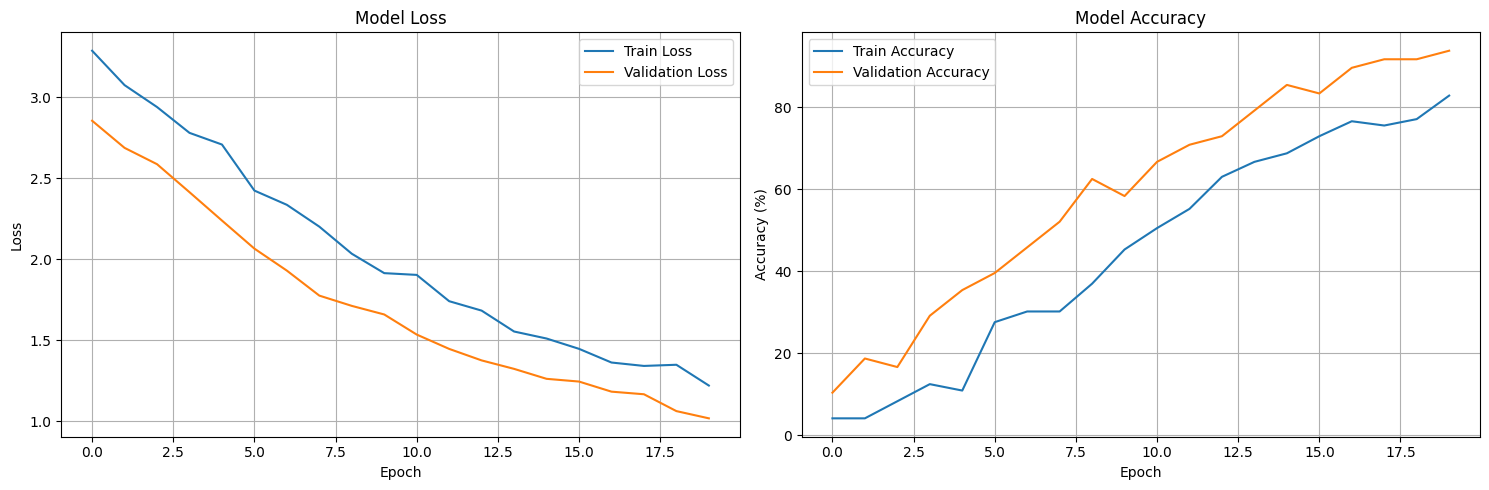

In [20]:
# Plot results
plot_training_history(history)

In [21]:
# Evaluate model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
evaluate_model(model, val_loader, label_encoder, device)

Evaluating: 100%|██████████| 3/3 [00:00<00:00,  4.56it/s]



Evaluation Results:
Accuracy: 0.9375
Precision: 0.9578
Recall: 0.9375
F1-Score: 0.9401

Detailed Classification Report:
                  precision    recall  f1-score   support

di_ứng_thực_phẩm       0.67      1.00      0.80         2
dị_ứng_thời_tiết       1.00      1.00      1.00         3
       hen_suyễn       1.00      1.00      1.00         2
    hạ_canxi_máu       1.00      1.00      1.00         1
         khô_mắt       0.50      1.00      0.67         1
    sốt_phát_ban       1.00      0.80      0.89         5
       thiếu_máu       1.00      0.80      0.89         5
       tiêu_chảy       1.00      1.00      1.00         4
             trĩ       1.00      1.00      1.00         3
         táo_bón       0.00      0.00      0.00         0
       viêm_khớp       1.00      1.00      1.00         4
 viêm_mũi_dị_ứng       0.86      1.00      0.92         6
   viêm_mũi_họng       1.00      0.75      0.86         4
      viêm_xoang       1.00      1.00      1.00         3
      vi

(0.9375, 0.9578373015873015, 0.9375, 0.9400539275539277)

# Hybrid Prediction

In [22]:
def predict_disease(model, tokenizer, label_encoder, text, device, max_length=256, top_k=3):
    model.eval()
    processed_text = preprocess_text(text)
    encoding = tokenizer(
        processed_text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = F.softmax(logits, dim=1).cpu().numpy()[0]
    top_indices = np.argsort(probs)[::-1][:top_k]
    top_labels = label_encoder.inverse_transform(top_indices)
    top_probs = probs[top_indices]
    return top_labels, top_probs, probs

def explain_prediction(top_labels, top_scores, threshold=0.5):
    if top_scores[0] >= threshold:
        return f"Bệnh dự đoán: {top_labels[0]} (độ tin cậy: {top_scores[0]:.2f})"
    else:
        return f"Có thể là: {', '.join(top_labels[:2])} (độ tin cậy: {top_scores[0]:.2f}, {top_scores[1]:.2f})"

In [23]:
def predict_disease_with_rules(text, disease_keywords, label_encoder):
    input_words = set(preprocess_text(text).lower().split())
    scores = []
    for label in label_encoder.classes_:
        keywords = set(disease_keywords.get(label, []))
        score = len(input_words & keywords) / (len(keywords) or 1)
        scores.append(score)
    return np.array(scores)

def hybrid_predict(model, tokenizer, label_encoder, text, device, disease_keywords, max_length=256, top_k=3, alpha=0.7):
    # Model prediction
    top_labels, top_probs, probs = predict_disease(model, tokenizer, label_encoder, text, device, max_length, top_k=len(label_encoder.classes_))
    # Rule-based prediction
    rule_scores = predict_disease_with_rules(text, disease_keywords, label_encoder)
    # Weighted sum
    combined = alpha * probs + (1 - alpha) * rule_scores
    top_indices = np.argsort(combined)[::-1][:top_k]
    top_labels = label_encoder.inverse_transform(top_indices)
    top_scores = combined[top_indices]
    return top_labels, top_scores, combined

def calculate_symptom_similarity(input_symptoms, disease_keywords):
    """Calculate similarity between input symptoms and disease keywords"""
    # Simple keyword matching - can be enhanced with word embeddings
    input_words = set(input_symptoms.lower().split())

    similarity_scores = {}
    for disease, keywords in disease_keywords.items():
        keyword_set = set(keywords)
        intersection = input_words.intersection(keyword_set)
        similarity = len(intersection) / len(keyword_set) if keyword_set else 0
        similarity_scores[disease] = similarity

    return similarity_scores

def enhanced_disease_prediction(model, tokenizer, label_encoder, text, device, max_length=256):
    """Enhanced prediction combining model prediction and rule-based matching"""

    # Get model prediction
    predicted_label, confidence, probabilities = predict_disease(
        model, tokenizer, label_encoder, text, device, max_length, top_k=3
    )

    # Calculate rule-based similarity
    similarity_scores = calculate_symptom_similarity(text, disease_keywords)

    # Combine model prediction with rule-based scoring
    combined_scores = {}
    for i, label in enumerate(label_encoder.classes_):
        model_score = probabilities[i]
        rule_score = similarity_scores.get(label, 0)
        # Weighted combination: 90% model, 10% rules
        combined_score = 0.9 * model_score + 0.1 * rule_score
        combined_scores[label] = combined_score

    # Get final prediction based on combined scores
    best_disease = max(combined_scores, key=combined_scores.get)
    best_combined_score = combined_scores[best_disease]

    # Sort by combined scores for top predictions
    sorted_diseases = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)

    print(f"\n📊 Detailed Analysis:")
    print(f"Model prediction: {predicted_label} (confidence: {confidence:.4f})")
    print(f"Rule-based enhancement: {best_disease} (combined score: {best_combined_score:.4f})")

    # Enhanced decision logic
    if best_combined_score > 0.3:  # Threshold for confident prediction
        final_prediction = best_disease
        final_confidence = best_combined_score
    else:
        # Low confidence - suggest multiple possibilities
        top_3 = [disease for disease, score in sorted_diseases[:3] if score > 0.1]
        if len(top_3) > 1:
            final_prediction = f"Có thể là: {', '.join(top_3[:2])}"
            final_confidence = sum([score for _, score in sorted_diseases[:2]]) / 2
        else:
            final_prediction = predicted_label
            final_confidence = confidence

    return final_prediction, final_confidence, sorted_diseases[:3]


In [24]:
from collections import Counter, defaultdict
from underthesea import word_tokenize
import re
def extract_keywords_from_symptoms(disease_data, max_keywords=8):
    """
    Trích xuất từ khóa quan trọng nhất cho mỗi bệnh từ các triệu chứng
    """
    print("Đang trích xuất từ khóa...")

    # Nhóm triệu chứng theo bệnh
    disease_symptoms = defaultdict(list)
    for symptom, disease in disease_data:
        disease_symptoms[disease].append(symptom)


    # Danh sách từ dừng (stop words) tiếng Việt
    stop_words = {
        'và', 'của', 'có', 'là', 'được', 'trong', 'với', 'cho', 'từ', 'trên',
        'theo', 'về', 'như', 'khi', 'nếu', 'để', 'này', 'đó', 'những', 'các',
        'một', 'hai', 'ba', 'bốn', 'năm', 'sáu', 'bảy', 'tám', 'chín', 'mười',
        'người', 'bệnh', 'nhân', 'bị', 'cảm', 'thấy', 'triệu', 'chứng', 'dấu',
        'hiệu', 'tình', 'trạng', 'xuất', 'hiện', 'gặp', 'phải', 'thường',
        'rất', 'khá', 'hơi', 'một', 'chút', 'ít', 'nhiều', 'lúc', 'khi'
    }

    disease_keywords = {}

    for disease, symptoms in disease_symptoms.items():
        # Kết hợp tất cả triệu chứng của bệnh
        all_symptoms_text = ' '.join(symptoms)

        # Tách từ bằng underthesea
        try:
            words = word_tokenize(all_symptoms_text.lower())
        except:
            # Fallback nếu underthesea lỗi
            words = all_symptoms_text.lower().split()

        # Lọc từ (loại bỏ từ dừng, từ quá ngắn, số)
        filtered_words = []
        for word in words:
            word = re.sub(r'[^\w]', '', word)  # Loại bỏ dấu câu

            # Xử lý từ ghép tự động: nếu từ có >= 4 ký tự và chứa 2+ âm tiết
            if len(word) >= 4 and word.isalpha():
                # Danh sách âm tiết phổ biến tiếng Việt để nhận diện
                syllable_patterns = [
                    'đau', 'khó', 'buồn', 'mệt', 'khát', 'sốt', 'nghẹt', 'chóng',
                    'hoa', 'đói', 'gầy', 'tê', 'cứng', 'sưng', 'khàn', 'nhức',
                    'căng', 'đầy', 'táo', 'lỏng', 'nóng', 'lạnh', 'ớn', 'chua'
                ]

                # Kiểm tra và tách từ ghép
                for pattern in syllable_patterns:
                    if word.startswith(pattern) and len(word) > len(pattern):
                        remaining = word[len(pattern):]
                        if len(remaining) >= 2:  # Phần còn lại phải >= 2 ký tự
                            word = pattern + '_' + remaining
                            break

            if (len(word) >= 2 and
                word not in stop_words and
                not word.isdigit() and
                (word.isalpha() or '_' in word)):  # Cho phép dấu gạch dưới
                filtered_words.append(word)

        # Đếm tần suất từ
        word_counts = Counter(filtered_words)

        # Lấy top từ khóa
        top_keywords = [word for word, count in word_counts.most_common(max_keywords)]

        disease_keywords[disease] = top_keywords

        print(f"{disease}: {len(symptoms)} triệu chứng -> {len(top_keywords)} từ khóa")

    return disease_keywords

In [25]:
disease_keywords = extract_keywords_from_symptoms(disease_data, max_keywords=4)

Đang trích xuất từ khóa...
tiêu_chảy: 15 triệu chứng -> 4 từ khóa
táo_bón: 15 triệu chứng -> 4 từ khóa
viêm_mũi_họng: 15 triệu chứng -> 4 từ khóa
khô_mắt: 15 triệu chứng -> 4 từ khóa
hạ_canxi_máu: 15 triệu chứng -> 4 từ khóa
sốt_phát_ban: 15 triệu chứng -> 4 từ khóa
viêm_xương: 15 triệu chứng -> 4 từ khóa
viêm_khớp: 15 triệu chứng -> 4 từ khóa
đau_dạ_dày: 15 triệu chứng -> 4 từ khóa
viêm_xoang: 15 triệu chứng -> 4 từ khóa
viêm_mũi_dị_ứng: 15 triệu chứng -> 4 từ khóa
thiếu_máu: 15 triệu chứng -> 4 từ khóa
hen_suyễn: 15 triệu chứng -> 4 từ khóa
di_ứng_thực_phẩm: 15 triệu chứng -> 4 từ khóa
dị_ứng_thời_tiết: 15 triệu chứng -> 4 từ khóa
trĩ: 15 triệu chứng -> 4 từ khóa


In [26]:
print(disease_keywords)

{'tiêu_chảy': ['tôi', 'nướctiểu', 'khô', 'da'], 'táo_bón': ['tôi', 'đau', 'bụng', 'đang'], 'viêm_mũi_họng': ['tôi', 'chảy', 'đau', 'mũi'], 'khô_mắt': ['tôi', 'mắt', 'cộm', 'hạtsạn'], 'hạ_canxi_máu': ['tôi', 'rốiloạn', 'trầmcảm', 'nhịp'], 'sốt_phát_ban': ['tôi', 'sưng', 'cùng', 'chán'], 'viêm_xương': ['da', 'tôi', 'khớp', 'viêm'], 'viêm_khớp': ['tôi', 'khớp', 'phátban', 'đỏ'], 'đau_dạ_dày': ['tôi', 'thở', 'mùi', 'đau'], 'viêm_xoang': ['tôi', 'mũi', 'đau', 'nhức'], 'viêm_mũi_dị_ứng': ['tôi', 'chảy', 'viêm', 'mũi'], 'thiếu_máu': ['tôi', 'da', 'xanhxao', 'niêmmạc'], 'hen_suyễn': ['thở', 'tôi', 'khó', 'đang'], 'di_ứng_thực_phẩm': ['tôi', 'sưng', 'môi', 'thở'], 'dị_ứng_thời_tiết': ['tôi', 'da', 'nổi', 'tụt'], 'trĩ': ['tôi', 'hậumôn', 'khối', 'trĩ']}


In [27]:

# Test predictions with symptom examples
test_cases = [
    " tôi bị chóng mặt buồn nôn",
    "tôi đang bị da bị phù lên, da bị xung huyết, nổi mề đay",
    "tôi bị Sốt cao trên 39.4 độ C,  phát ban, khó chịu, chán ăn"
]

print(f"\n{'='*60}")
print("TESTING DISEASE PREDICTION:")
print(f"{'='*60}")

for test_text in test_cases:
    print(f"\nSymptoms: {test_text}")

    top_labels, top_scores, combined = hybrid_predict(
        model, tokenizer, label_encoder, test_text, device, disease_keywords, max_length=256, top_k=3, alpha=0.7
    )
    print(explain_prediction(top_labels, top_scores))

    # Show top 3 predictions
    print("Top 3 predictions:")
    for i, label in enumerate(top_labels):
        print(f"  {i+1}. {label}: {top_scores[i]:.4f}")
    print("-" * 50)



TESTING DISEASE PREDICTION:

Symptoms:  tôi bị chóng mặt buồn nôn
Có thể là: khô_mắt, di_ứng_thực_phẩm (độ tin cậy: 0.29, 0.18)
Top 3 predictions:
  1. khô_mắt: 0.2876
  2. di_ứng_thực_phẩm: 0.1815
  3. hạ_canxi_máu: 0.1723
--------------------------------------------------

Symptoms: tôi đang bị da bị phù lên, da bị xung huyết, nổi mề đay
Bệnh dự đoán: dị_ứng_thời_tiết (độ tin cậy: 0.78)
Top 3 predictions:
  1. dị_ứng_thời_tiết: 0.7825
  2. viêm_xương: 0.1660
  3. thiếu_máu: 0.1600
--------------------------------------------------

Symptoms: tôi bị Sốt cao trên 39.4 độ C,  phát ban, khó chịu, chán ăn
Có thể là: sốt_phát_ban, dị_ứng_thời_tiết (độ tin cậy: 0.25, 0.21)
Top 3 predictions:
  1. sốt_phát_ban: 0.2482
  2. dị_ứng_thời_tiết: 0.2056
  3. tiêu_chảy: 0.1901
--------------------------------------------------


In [28]:
# Save the trained model and tokenizer for future use
print("\nSaving trained model...")
torch.save({
    'model_state_dict': model.state_dict(),
    'label_encoder': label_encoder,
    'config': config
}, 'vihealthbert_disease_model.pth')

print("✓ Model saved successfully!")


Saving trained model...
✓ Model saved successfully!
